<center>
<img src="../../img/ods_stickers.jpg">
## Opendatascience Course
<center>Author: Egor Labintcev – @egor_labintcev

<img src="https://habrastorage.org/web/04d/883/420/04d8834204974f0baf14dc277b634e16.jpg"/>

                         **Random picture from Google with query "class imbalance" P.S. in russian**

## Long story short

In classification tasks balance is usually broken and target class is usually the smallest one.

Fraud, technical failures, medical diagnosis, spam in search, churn prediction -- you name it.

Why classical algorithms perform not so good?

Roughly spearking, the problem is inside these algorithms -- usually there is an optimization of the [loss](https://en.wikipedia.org/wiki/Loss_function) function, which doesn't take in account the class imbalance. That's why the model tries to predict **more** objects of **bigger** class ignoring smaller one, but decreasing overall error-rate.

In this tutorial we will look at several methods, which can handle the imbalance problem.

That's the plan:

* Internal parameters of algorithms (+ one special algortihm for imbalance problems)
* imbalanced-learn library

We will use poker hands' data, where features are Suit and Rank, and target is Poker Hand, i.e. various combination of hands. You can download it [here](https://archive.ics.uci.edu/ml/datasets/Poker+Hand)

A bit about features: :

```
1) S1 "Suit of card #1" 
Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs} 

2) C1 "Rank of card #1" 
Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King
```

A bit about target of [data](https://archive.ics.uci.edu/ml/datasets/Poker+Hand):

```
0: Nothing in hand; not a recognized poker hand
1: One pair; one pair of equal ranks within five cards
2: Two pairs; two pairs of equal ranks within five cards
3: Three of a kind; three equal ranks within five cards
4: Straight; five cards, sequentially ranked with no gaps
5: Flush; five cards with the same suit
6: Full house; pair + different rank three of a kind
7: Four of a kind; four equal ranks within five cards
8: Straight flush; straight + flush
9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush 
```

I'm not a professional poker player but:
the bigger the number, the smaller the class and the position is better.

For examples you will need .py [script](https://github.com/silicon-valley-data-science/learning-from-imbalanced-classes/blob/master/blagging.py) blagging.py, which you should put near your jupyter notebook, and library [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/index.html):

`pip install -U imbalanced-learn`

or with Anaconda 

`conda install -c glemaitre imbalanced-learn`

In [5]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn import neighbors
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

## Internal parameters of algorithms

Load the data and have a look:

In [7]:
def load_and_prepare_data():
    
    # Loading data

    df = pd.read_csv('poker-hand-training-true.data', 
                     names=['Suit1', 'C1', 'Suit2', 'C2', 'Suit3', 
                            'C3', 'Suit4', 'C4', 'Suit5', 'C5', 'CLASS'])
    
    # encoding of ordinal features -- another matter, here we will use simple one-hot

    ordinal_columns = [col for col in df.columns if 'Suit' in col]

    ohe = OneHotEncoder(sparse=False)
    encoded_ordinal = ohe.fit_transform(df[ordinal_columns])

    # delete original columns
    df.drop(ordinal_columns, axis=1, inplace=True)
    
    tmp = pd.DataFrame(encoded_ordinal, columns=['S ' + str(i) for i in range(encoded_ordinal.shape[1])])
    df = pd.concat([df, tmp], axis=1)
    
    return df

In [8]:
df = load_and_prepare_data()

In [9]:
df.head(10)

,C1,C2,C3,C4,C5,CLASS,S 0,S 1,S 2,S 3,...,S 10,S 11,S 12,S 13,S 14,S 15,S 16,S 17,S 18,S 19
0,10,11,13,12,1,9,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,11,13,10,12,1,9,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,12,11,13,10,1,9,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,10,11,1,13,12,9,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,13,12,11,10,9,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,2,4,5,3,6,8,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,9,12,10,11,13,8,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1,2,3,4,5,8,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,5,6,9,7,8,8,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,1,4,2,3,5,8,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Have a look at the distribution of class to estimate how imbalanced our data is.

In [10]:
# Distributions of the classes

print("Initial class percentages: \n")
df.CLASS.value_counts()

Initial class percentages: 



0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
9        5
8        5
Name: CLASS, dtype: int64

In [11]:
X = df.drop('CLASS', axis=1).as_matrix()
y = df.CLASS

Let's look at the quality of algorithms as is. Of course, we should preliminary break the data into train and test.

When you look on metrics, pay attention to recall of classes or to F1-score. 

In [12]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

In [13]:
from sklearn.metrics import classification_report

In [14]:
clf = RandomForestClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.55      0.70      0.62      4997
          1       0.48      0.41      0.45      4240
          2       0.10      0.00      0.01       482
          3       0.25      0.00      0.01       205
          4       0.00      0.00      0.00        37
          5       0.00      0.00      0.00        22
          6       0.00      0.00      0.00        14
          7       0.00      0.00      0.00         3
          8       0.00      0.00      0.00         2
          9       0.00      0.00      0.00         2

avg / total       0.49      0.53      0.50     10004



/home/egor/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As we see, the rarest classes weren't found by default RandomForest and he swears with having no predictions on them. 

Imagine for a second, that we are interested in classes from 6 to 9 inclusive. Those classes are rare, but they sharply increase the winning probability. Let's try to tune weights to find these classes.

In several algorithms there is an option to put on "class_weight". For example, all your favorite logistic regression and random forest can adjust the cost for the incorrectly predicted object. The alternative to manual tuning is "balanced" option, which puts weights using distribution of train data.

In [15]:
searching_for_classes = ['balanced', 
                         {6:2, 7:2, 8:2, 9:2},
                         {6:10, 7:10, 8:10, 9:10}
                        ]

In [16]:
for option in searching_for_classes:
    
    clf = RandomForestClassifier(class_weight=option, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)

    print(classification_report(y_test, clf.predict(X_test)))

/home/egor/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/egor/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.54      0.69      0.60      4997
          1       0.46      0.38      0.42      4240
          2       0.00      0.00      0.00       482
          3       0.17      0.00      0.01       205
          4       0.00      0.00      0.00        37
          5       1.00      0.14      0.24        22
          6       0.00      0.00      0.00        14
          7       0.00      0.00      0.00         3
          8       0.00      0.00      0.00         2
          9       0.00      0.00      0.00         2

avg / total       0.47      0.51      0.48     10004

             precision    recall  f1-score   support

          0       0.55      0.70      0.62      4997
          1       0.47      0.40      0.43      4240
          2       0.17      0.01      0.02       482
          3       0.00      0.00      0.00       205
          4       0.00      0.00      0.00        37
          5       0.00      0.00      0.00

/home/egor/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Let's look at ExtraTreesClassifier

In [17]:
for option in searching_for_classes:
    
    clf = ExtraTreesClassifier(class_weight=option, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)

    print('weights: ' + str(option) + '\n' + classification_report(y_test, clf.predict(X_test)) + '\n' )

/home/egor/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/egor/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


weights: balanced
             precision    recall  f1-score   support

          0       0.52      0.66      0.58      4997
          1       0.44      0.37      0.41      4240
          2       0.05      0.01      0.01       482
          3       0.00      0.00      0.00       205
          4       0.00      0.00      0.00        37
          5       0.82      0.41      0.55        22
          6       0.00      0.00      0.00        14
          7       0.00      0.00      0.00         3
          8       0.00      0.00      0.00         2
          9       0.00      0.00      0.00         2

avg / total       0.45      0.49      0.46     10004


weights: {8: 2, 9: 2, 6: 2, 7: 2}
             precision    recall  f1-score   support

          0       0.51      0.64      0.57      4997
          1       0.43      0.37      0.40      4240
          2       0.05      0.01      0.02       482
          3       0.03      0.00      0.01       205
          4       0.33      0.03      0.05

/home/egor/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In first case (with "balanced") we now find 5-th class. But it is not what we expected. Let's have a look on probabilities, which classifier assigns to each of objects.

In [18]:
predicted_probs = clf.predict_proba(X_test)

In [19]:
pd.DataFrame(predicted_probs, 
             columns=['prob_' + str(i) for i in range(0,10)]) \
             [["prob_6", "prob_7", "prob_8", "prob_9"]].describe()

,prob_6,prob_7,prob_8,prob_9
count,10004.000000,10004.000000,10004.000000,10004.000000
mean,0.001999,0.000250,0.000200,0.000280
std,0.018865,0.007275,0.005094,0.006157
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.500000,0.500000,0.200000,0.300000


We can use simple trick: adjust the threshold of probabilities, i.e. assign a class with lower than 0.5 probability to catch some objects of the class. But we can see that this approach doesn't make sense -- probabilities are low and there are few examples to catch.

We will come back to the problem of detecting such small classes.

### Blagging Classifier

Let's have a look at Blagging Classifier, which is out-of-the-box capable to balance classes.


Great intuitive explanation of its work is [here](https://github.com/silicon-valley-data-science/learning-from-imbalanced-classes/blob/master/Gaussians.ipynb), and the paper about this approach is [here](https://pdfs.semanticscholar.org/a8ef/5a810099178b70d1490a4e6fc4426b642cde.pdf).

Source code is here [here](https://github.com/silicon-valley-data-science/learning-from-imbalanced-classes/blob/master/blagging.py).

How it works:

* Bootstraping data
* Balancing with downsampling (reducting the bigger class fraction)
* Learning Decision Tree on each of the samples
* Majority vote from several trees

<img src="https://habrastorage.org/web/29a/31c/af6/29a31caf67f8449dace109394b8b7e6a.png"/>

Picture from [here](https://svds.com/learning-imbalanced-classes/)

Unfortunately, this classifier works only with binary classification, so we will turn the task to binary problem. Now we have rare but winning classes and several classes with many objects, but not winning -- worst combinations.

In [20]:
df = load_and_prepare_data()

In [22]:
# Look again at the distribution of classes

df.CLASS.value_counts()

0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
9        5
8        5
Name: CLASS, dtype: int64

In [23]:
def make_binary(original_data, pos_classes):
    return np.array([(1 if val in pos_classes else 0)
                     for val in original_data ])

In [24]:
binary_y = make_binary(df.CLASS, set((4, 5, 6, 7, 8, 9)))
print("After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 \n")

np.unique(binary_y, return_counts=True)

After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 



(array([0, 1]), array([24811,   199]))

This problem is still an umbalanced one, so we can try sklearn and compare it to BlaggingClassifier.

In [25]:
X = df.drop('CLASS', axis=1).as_matrix()
y = binary_y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

RandomForest:

In [26]:
clf = RandomForestClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      9924
          1       0.00      0.00      0.00        80

avg / total       0.98      0.99      0.99     10004



/home/egor/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


GradientBoosting:

In [27]:
clf = GradientBoostingClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      9924
          1       1.00      0.01      0.02        80

avg / total       0.99      0.99      0.99     10004



Nothing is changed substantially even after merging classes.

In [30]:
from blagging import BlaggingClassifier

clf = BlaggingClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      0.88      0.94      9924
          1       0.03      0.44      0.05        80

avg / total       0.99      0.88      0.93     10004



As we see, BlaggingClassifier showed very good quality of prediction (see recall).

ExtraTreesClassifier was a surprise:

In [32]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      9924
          1       0.85      0.21      0.34        80

avg / total       0.99      0.99      0.99     10004



We can think (but we won't) about merging predictions from ExtraTreesClassifier and BlaggingClassifier to achieve even better results.

Now let's have a look at AUC-ROC for each of the classifiers. I should mention that it is better to estimate AUC-ROC during crossvalidation, because some of the class objects can be non-typical to class and we can catch them when splitting. This approach reduces bias but we use train-test split for demonstration of methods.

In [33]:
clfs = [
        ['RandomForestClassifier', RandomForestClassifier(random_state=RANDOM_STATE)],
        ['GradientBoostingClassifier', GradientBoostingClassifier(random_state=RANDOM_STATE)],
        ['ExtraTreesClassifier', ExtraTreesClassifier(random_state=RANDOM_STATE)], 
        ['BlaggingClassifier', BlaggingClassifier(random_state=RANDOM_STATE)]
       ]

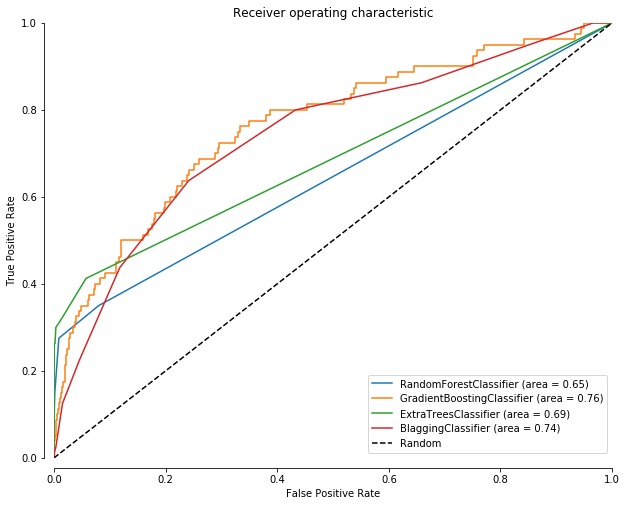

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, clf in clfs:
    
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, linestyle='-',
             label='{} (area = %0.2f)'.format(name) % roc_auc)
    
plt.plot([0, 1], [0, 1], linestyle='--', color='k',
         label='Random')    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.legend(loc="lower right")

plt.show()    

You can see that with focusing more on bigger class, GradientBoosting performs a bit better than BlaggingClassifier.
But let's look at AUC-PR and everything will fall into place.

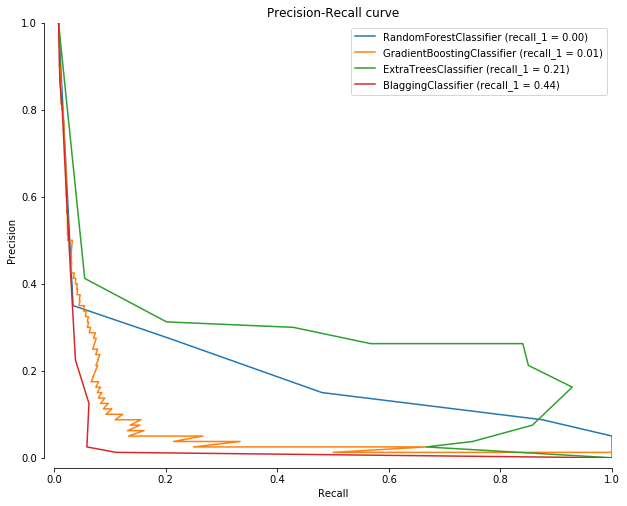

In [35]:
from sklearn.metrics import recall_score

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, clf in clfs:
    
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    recall_1 = recall_score(y_test, clf.predict(X_test))
    plt.plot(fpr, tpr, linestyle='-',
             label='{} (recall_1 = %0.2f)'.format(name) % recall_1)
    
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')

plt.legend(loc="upper right")

plt.show()    

Now it is clear that BlaggingClassifier gives biggest recall of the smallest class.

## Library imbalanced-learn

[Library](http://contrib.scikit-learn.org/imbalanced-learn/install.html) imbalanced-learn allows to use various techniques of sampling (over, under and their combinations). Some approaches have non-trivial theory behind (too long for this tutorial) but I left some links.

Library has:

* Under-sampling methods. It is simple, we sample from bigger class for balancing the train data. Two options possible:
 - generation of new examples of bigger class using [centroids](http://contrib.scikit-learn.org/imbalanced-  learn/generated/imblearn.under_sampling.ClusterCentroids.html) of clusters;
 - [choosing](http://contrib.scikit-learn.org/imbalanced-learn/api.html#module-imblearn.under_sampling.prototype_selection) objects of bigger class with many options (there is a lot)


* Over-sampling methods. It is simple either -- we are adding the samples from minor class just [copying](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.over_sampling.RandomOverSampler.html) or using more sophisticated techniques such as [SMOTE](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html), which allows to generate synthetic examples based on closeness of several neighbours in feature space (with a bit of randomness). [Here](https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/node6.html#SECTION00042000000000000000) you can find more about it.

Let's look at the behaviour of these methods on the original data.

In [36]:
df = load_and_prepare_data()

X = df.drop('CLASS', axis=1).as_matrix()
y = df.CLASS

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

In [37]:
df.CLASS.value_counts()

0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
9        5
8        5
Name: CLASS, dtype: int64

Simple undersampling:

In [39]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler

pipe = make_pipeline(RandomUnderSampler(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

In [40]:
pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.49      0.15      0.23      4997
          1       0.43      0.18      0.26      4240
          2       0.05      0.10      0.06       482
          3       0.02      0.08      0.03       205
          4       0.00      0.08      0.01        37
          5       0.00      0.23      0.01        22
          6       0.00      0.00      0.00        14
          7       0.00      0.33      0.00         3
          8       0.00      0.00      0.00         2
          9       0.00      0.00      0.00         2

avg / total       0.43      0.16      0.22     10004



Better (see classes 4, 5 and 7), but we lost our performance on big classes.

Try [CondensedNearestNeighbour](http://machinelearning.org/proceedings/icml2005/papers/004_Fast_Angiulli.pdf):

In [41]:
from imblearn.under_sampling import CondensedNearestNeighbour

pipe = make_pipeline(CondensedNearestNeighbour(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.51      0.33      0.40      4997
          1       0.43      0.41      0.42      4240
          2       0.04      0.11      0.06       482
          3       0.02      0.14      0.04       205
          4       0.00      0.00      0.00        37
          5       0.25      0.73      0.37        22
          6       0.00      0.00      0.00        14
          7       0.00      0.00      0.00         3
          8       0.00      0.00      0.00         2
          9       0.00      0.00      0.00         2

avg / total       0.44      0.35      0.38     10004



Even better, we see bigger classes again (though we lost some minor classes)!

I should mention, that not all of the methods in imbalanced-learn work for multi-class tasks. We can return to binary formulation to demonstration of over-sampling methods.

In [42]:
df = load_and_prepare_data()
binary_y = make_binary(df.CLASS, set((4, 5, 6, 7, 8, 9)))

print("After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 \n")

np.unique(binary_y, return_counts=True)
X = df.drop('CLASS', axis=1).as_matrix()
y = binary_y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 



In [43]:
from imblearn.over_sampling import RandomOverSampler

pipe = make_pipeline(RandomOverSampler(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      9924
          1       0.90      0.24      0.38        80

avg / total       0.99      0.99      0.99     10004



Even simple over-sampling works fine.

In [44]:
from imblearn.over_sampling import SMOTE

pipe = make_pipeline(SMOTE(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      9924
          1       0.79      0.29      0.42        80

avg / total       0.99      0.99      0.99     10004



imlearn has its own metric including precision, recall, specificity (true negative rate), f1, geometric mean recall and specificity, also index balanced
[accuracy](http://repositori.uji.es/xmlui/bitstream/handle/10234/23961/33068.pdf?sequence=1).

Last one is:

$$ IBA = (1 + Dominance)· Gmean^2 ,$$
    where
$$ Dominance = True Positive Rate - True Negative Rate $$

In [ ]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, pipe.predict(X_test)))

And let's build some ROC for our methods.

In [45]:
class DummySampler(object):

    def sample(self, X, y):
        return X, y

    def fit(self, X, y):
        return self

    def fit_sample(self, X, y):
        return self.sample(X, y)

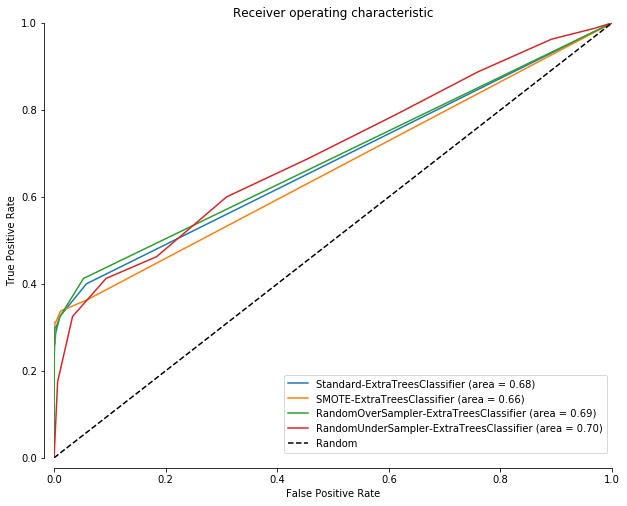

In [46]:
classifier = ['ExtraTreesClassifier', ExtraTreesClassifier()]

samplers = [
    ['Standard', DummySampler()],
    ['SMOTE', SMOTE(random_state=RANDOM_STATE)],
    ['RandomOverSampler', RandomOverSampler(random_state=RANDOM_STATE)],
    ['RandomUnderSampler', RandomUnderSampler(random_state=RANDOM_STATE)]
]

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], classifier[1])]
    for sampler in samplers
]


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, clf in pipelines:
    
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, linestyle='-',
             label='{} (area = %0.2f)'.format(name) % roc_auc)
    
plt.plot([0, 1], [0, 1], linestyle='--', color='k',
         label='Random')    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.legend(loc="lower right")

plt.show()    

## Conclusions

* Practice makes perfect. Try various approaches to your tasks and combine them.
* Look inside your problem, not your metric. You're not tuning percents, you're solving the task.

Links:

* [Documentation](http://contrib.scikit-learn.org/imbalanced-learn/index.html) imbalanced-learn
* [Post](https://svds.com/learning-imbalanced-classes/) about working with imbalanced classes, [FAQ](https://svds.com/imbalanced-classes-faq/) and [repo](https://github.com/silicon-valley-data-science), where I found BlaggingClassifier and took some code

